In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, roc_curve, auc
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
import nibabel as nib
import os
import pickle
from torch import nn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 1
# Load data
nrows = 256
ncols = 256
nslices = 160
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/home/ali/RadDBS-QSM/data/nii/chh/orig/qsm/'
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)
qu_directory = '/home/ali/RadDBS-QSM/data/nii/chh/lr_roi_ft'
qu_directory = os.listdir(qu_directory)
qu_directory = sorted(qu_directory)
s_directory = '/home/ali/RadDBS-QSM/data/nii/chh/orig/seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)
m_directory = '/home/ali/RadDBS-QSM/data/nii/chh/masks'
m_directory = os.listdir(m_directory)
m_directory = sorted(m_directory)
case_list = []
d_count = 0
if visualize == 1:
    for filename in q_directory:
    
        seg_filename = s_directory[d_count]
        laro_filename = qu_directory[d_count]
        mask_filename = m_directory[d_count]
        seg = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/orig/seg/'+seg_filename)
        mask = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/masks/'+mask_filename)
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata()[:nrows,:ncols,:nslices])
        qsm = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/orig/qsm/'+filename)
        qsms.append(qsm.get_fdata()[:nrows,:ncols,:nslices])

        laro = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/lr_roi_ft/'+laro_filename)
        laros.append(1000*laro.get_fdata()[:nrows,:ncols,:nslices])
        print('Appending arrays with segmentation',seg_filename,'QSM,',filename,
              'LARO,',laro_filename,'and mask',mask_filename)
        case_list.append(filename)
        n_cases = len(segs)
        d_count = d_count+1




Appending arrays with segmentation 01_roi_combined.nii QSM, 00001_qsm.nii.gz LARO, QSM_lrr_01.nii and mask mask01.nii
Appending arrays with segmentation 02_roi_combined.nii QSM, 00002_qsm.nii.gz LARO, QSM_lrr_02.nii and mask mask02.nii
Appending arrays with segmentation 03_roi_combined.nii QSM, 00003_qsm.nii.gz LARO, QSM_lrr_03.nii and mask mask03.nii
Appending arrays with segmentation 04_roi_combined.nii QSM, 00004_qsm.nii.gz LARO, QSM_lrr_04.nii and mask mask04.nii
Appending arrays with segmentation 05_roi_combined.nii QSM, 00005_qsm.nii.gz LARO, QSM_lrr_05.nii and mask mask05.nii
Appending arrays with segmentation 06_roi_combined.nii QSM, 00006_qsm.nii.gz LARO, QSM_lrr_06.nii and mask mask06.nii
Appending arrays with segmentation 07_roi_combined.nii QSM, 00007_qsm.nii.gz LARO, QSM_lrr_07.nii and mask mask07.nii
Appending arrays with segmentation 08_roi_combined.nii QSM, 00008_qsm.nii.gz LARO, QSM_lrr_08.nii and mask mask08.nii
Appending arrays with segmentation 09_roi_combined.nii Q

In [4]:
df = pd.read_csv('/home/ali/RadDBS-QSM/data/xlxs/updrs_iii_chh.csv')
df

,subjects,LCT,Unnamed: 2,UPDRSⅢ,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,Preoperative Off-Medicine,Preoperative On-Medicine,Postoperative Off-Medicine &Off-Stimulation\n,Postoperative Off-Medicine &On-Stimulation,Postoperative On-Medicine &On-Stimulation,NaN
1,1.0,62.26%,NaN,53,20,40,15,7,NaN
2,2.0,75.00%,NaN,32,8,26,17,10,NaN
3,3.0,51.72%,NaN,58,28,52,18,20,NaN
4,4.0,22.58%,NaN,62,48,61,36,28,NaN
5,5.0,55.88%,NaN,34,15,44,29,22,NaN
6,6.0,75.44%,NaN,57,14,55,32,16,NaN
7,7.0,84.00%,NaN,100,16,68,12,NaN,NaN
8,8.0,41.86%,NaN,43,25,48,26,26,NaN
9,9.0,72.58%,NaN,62,17,56,25,11,NaN


In [5]:
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]

# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][:2])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
for i in np.arange(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')


Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 01_roi_combined.nii for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 02_roi_combined.nii for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 03_roi_combined.nii for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 04_roi_combined.nii for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 05_roi_combined.nii for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 06_roi_combined.nii for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 07_roi_combined.nii for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 08_roi_combined.nii for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 09_roi_combined.nii for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 10_roi_combined.nii for case 10.0
Found ROIs [0. 1. 2

In [6]:
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])                                
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])
post_updrs_iii_off =  np.asarray(df[df.columns[6]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])

per_change = (np.asarray(pre_updrs_iii_off).astype(float)-np.asarray(post_updrs_iii_off).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))
lct_change = (np.asarray(pre_updrs_iii_off).astype(float)-(np.asarray(pre_updrs_iii_on)).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))

In [7]:
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

reextract = 0

# Assume all voxel sizes are identical
voxel_size = (0.9,0.9,0.9)
if reextract == 1:
    # Generate feature structure Phi from all ROIs and all cases
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.enableAllFeatures()
    extractor.enableAllImageTypes()
    extractor.enableFeatureClassByName('shape2D',enabled = False)

    seg_labels_all = np.unique(np.asarray(segs))
    Phi_gt = []
    Phi_vd = []
    Phi_lr = []
    seg_labels = []
    reextract = 0
    x_row_gt = []
    x_row_lr = []

    keylib = []
    roilib = []
    loop_count = 1
    n_rois = seg_labels_all[seg_labels_all>0].__len__()
    roi_names = np.asarray(['Background','Right substantia nigra','Right subthalamic nucleus',
                            'Left subthalamic nucleus', 'Left substantia nigra', 'Right dentate nucleus', 'Left dentate nucleus'])
    for i in np.arange(subject_id_corr.__len__()):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_size)
        qsm_sitk_gt = sitk.GetImageFromArray(qsms[i])
        qsm_sitk_gt.SetSpacing(voxel_size)
        qsm_sitk_lr = sitk.GetImageFromArray(laros[i])
        qsm_sitk_lr.SetSpacing(voxel_size)
        # Index back since subject 12 is missing ROIs
        for j in seg_labels_all:
            if j>0:
                fv_count = 0
                featureVector_gt = extractor.execute(qsm_sitk_gt,seg_sitk,label=int(j));
                featureVector_lr = extractor.execute(qsm_sitk_lr,seg_sitk,label=int(j));
                Phi_gt.append(featureVector_gt)
                Phi_lr.append(featureVector_lr)
                for key, value in six.iteritems(featureVector_gt):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row_gt.append(featureVector_gt[key])
                        x_row_lr.append(featureVector_lr[key])
                        fv_count = fv_count+1
                        keylib.append(key)
                        roilib.append(roi_names[int(j)])
                x_row_gt.append(pre_updrs_iii_off[i])
                x_row_lr.append(pre_updrs_iii_off[i])
                fv_count = fv_count+1
        print('Extracting features for subject',subject_id_corr[i],'and appending feature matrix with vector of length',fv_count,'with UPDRS score',pre_updrs_iii_off[i])
                
    X0_gt = np.array(x_row_gt)
    X0_lr = np.array(x_row_lr)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy',X0_gt)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/X0_lr_chh_rois_rp.npy',X0_lr)

    K = np.asarray(keylib)
    R = np.asarray(roi_names)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy',K)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy',R)

    print('Saving ground truth feature vector')
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_gt, fp)
    
    print('Saving undersampled feature vector')
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_lr_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_lr, fp)

else:
    X0_gt = np.load('/home/ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy')
    X0_lr = np.load('/home/ali/RadDBS-QSM/data/npy/rp/X0_lr_chh_rois_rp.npy')
    K = np.load('/home/ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy')
    R = np.load('/home/ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy')
    n_rois = R.shape[0]-1
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', "rb") as fp:  
        Phi_gt = pickle.load(fp)
    
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_lr_roi_chh_rp', "rb") as fp:  
        Phi_lr = pickle.load(fp)

    

In [8]:
n_features = 1596
n_rois = 6
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)[:,0:4,:]
K_all_c = K.reshape(n_cases,n_rois,n_features-1)[:,0:4,:]
K_all_c = K_all_c[0,:,:].reshape(-1,1)

In [9]:
n_cases = len(per_change)
n_roisc = Phi_gt.__len__()/n_cases
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
subsc = subject_id_corr
pre_updrs_off = pre_updrs_iii_off
results_ls_aug = np.zeros_like(per_change)

results_lgr_aug = np.zeros_like(per_change)
results_lgrp_aug = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_lgr = np.zeros_like(per_change)
results_lgrp = np.zeros_like(per_change)
r = 1

In [10]:
# Noise compensated LASSO
retrain = 1
K_nz_nc = []
if retrain == 1:

  Js = []
  aug = True
  err_var = np.zeros_like(per_change)
  rerror = np.zeros_like(per_change)
  kappa = []
  K_nz = []
  E_nz = []
  c = 0

  K_all_c = np.append(K_all_c,['pre updrs']*5)
  for j in np.arange(len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
                                            
      X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_off,None,None,None,None,None,None,None,None,None,False,False,False)
      cvn = 5
      cv_scores = np.zeros((cvn,1))
      cv_lgr_scores = np.zeros((cvn,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train)
      kappa = stats.skew(y_train)
      print('Label distribution of:',mu,sigma,kappa)
      for jj in np.arange(2,cvn):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
          y_train = np.append(y_train,y_train[idyr])
          y_cat = y_train <= 0.3
          rs = rs+1
          print('Resampled to size',y_train.shape)
        if aug == True:
          y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
          y_train = np.hstack((y_train,y_train_n))
          y_cat = y_train <= 0.3
          X0_ss0 = np.vstack((X0_ss0,X0_ss0))
      
      for jj in np.arange(2,cvn):
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          # Feature selection
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen,n_jobs=1)
          # Stratifies classifiers automatically
          sel_lr = skf.RFECV(lgr,step=rcfs,cv=jj,n_jobs=1)
          X0_ss = sel.fit_transform(X0_ss0,y_train)
          # X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
          est_ls = lasso.fit(X0_ss,y_train)
          # est_lgr = lgr.fit(X0_ssl,y_cat)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          # cv_lgr_scores[jj] = est_lgr.score(X0_ssl,y_cat)
          print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        best_cv_lgr = np.argmax(cv_lgr_scores)

        # Break any ties
        if np.sum(cv_scores == best_cv) > 1:
          cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
          cv_lgr_scores_tb = np.zeros((np.sum(cv_scores == best_cv_lgr),1))
          for jjj in (cv_scores == cv_scores[best_cv]):
            if jjj > 0:
              print('Breaking tie')
              skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
              skf_gen = skf_g.split(X0_ss0,y_cat) 
              X0_ss = sel.fit_transform(X0_ss0,y_train)
              X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
              est_ls = lasso.fit(X0_ss,y_train)
              # est_lgr = lgr.fit(X0_ssl,y_cat)
              lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
              # lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
              est_ls = lasso.fit(X0_ss,y_train)
              # est_lgr = lgr.fit(X0_ssl,y_cat)
              cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
              # cv_lgr_scores_tb[jj] = est_lgr.score(sel_lr.fit_transform(X0_ss0,y_cat),y_cat)
          best_cv = np.argmax(cv_scores_tb)
          best_cv_lgr = np.argmax(cv_lgr_scores_tb)
        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        sel_lr = skf.RFECV(lgr,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
        X_test_ssl = sel_lr.transform(X_test_ss0)
        K_ss = sel.transform(K_all_c.reshape(1,-1))

      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv,class_weight=None)
        est_ls = lasso.fit(X0_ss,y_train)
      #   est_lgr = lgr.fit(X0_ssl,y_cat)
      # results_lgr_aug[c] = est_lgr.predict(X_test_ssl)
      # results_lgrp_aug[c] = est_lgr.predict_proba(X_test_ssl)[0][0]
      results_ls_aug[c] = est_ls.predict(X_test_ss)
      print('Lasso predicts',str(np.round(results_ls_aug[c],4)),'and logistic regression predicts',results_lgr_aug[c],
                'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv,'and',sum(y_cat),'minority cases')
      K_nz.append(np.squeeze(K_ss)[est_ls.coef_>0])
      # E_nz.append(est_ls.coef_[est_ls.coef_>0])
      c=c+1

  # np.save('results_ls_aug_d.npy',results_ls_aug)
  # np.save('results_lgr_aug_d.npy',results_lgr_aug)
  # np.save('results_lgrp_aug_d.npy',results_lgrp_aug)

else:
  results_ls_aug = np.load('results_ls_aug_d.npy')
  results_lgr_aug = np.load('results_lgr_aug_d.npy')
  #results_lgrp_aug = np.load('results_lgr_aug_d.npy')

  


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.49930282] from dataset of size (304, 1385)
LassoCV score for 3 is [0.49100545] from dataset of size (304, 1385)
LassoCV score for 4 is [0.49930282] from dataset of size (304, 385)
Lasso predicts 0.6384 and logistic regression predicts 0.0 for case with 0.72 and selected CV 2 and 82 minority cases
Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.50045498] from dataset of size (304, 6385)
LassoCV score for 3 is [0.49602442] from dataset of size (304, 2385)
LassoCV score for 4 is [0.50045498] from dataset of size (304, 2385)
Lasso predicts 0.4416 and logistic regression predicts 0.0 for case with 0.47 and selected CV 4 and 80 minority cases
Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
Resampl

In [11]:
# Vanilla LASSO
aug = False
K_nz_vl = []
c = 0
for j in np.arange(c,len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    idy = np.where(y_cat==1)
    # Cross validation
                                          
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs_off,None,None,None,None,None,None,None,None,None,False,False,False)
    X0_ss00 = X0_ss0
    y_train_0 = y_train
    cvn = 5

    cv_scores = np.zeros((cvn,1))
    rs = 1
    rcfs = 1000
    (mu, sigma) = stats.norm.fit(y_train)
    kappa = stats.skew(y_train)
    print('Label distribution of:',mu,sigma,kappa)
    for jj in np.arange(2,cvn):
      # Resample to avoid stratification errors
      while np.sum(y_cat) < cvn:
        np.random.seed(rs)
        idyr = np.random.choice(np.asarray(idy).ravel())
        X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
        y_train = np.append(y_train,y_train[idyr])
        y_cat = y_train <= 0.3
        rs = rs+1
        print('Resampled to size',y_train.shape)
        ls0 = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        est0 = ls0.fit(X0_ss0,y_train)
        eps = y_train-ls0.predict(X0_ss0)
        eps_v = eps*np.random.normal(0,1,1)
        y_train_0 = y_train
      if aug == True:
        y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
        y_train = np.hstack((y_train,y_train_n))
        y_cat = y_train <= 0.3
        X0_ss0 = np.vstack((X0_ss0,X0_ss0))
      # else: # Control for different training sample sizes
      #   while len(eps_v) < len(y_train):
      #     eps_v = np.hstack((eps_v,eps*np.random.normal(0,1,1)))
      #   y_train_n = y_train+eps_v
      #   y_train = np.hstack((y_train,y_train_n))
      #   y_cat = y_train <= 0.3
      #   X0_ss0 = np.vstack((X0_ss0,X0_ss0))

    for jj in np.arange(2,cvn):
      skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        # Feature selection
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X0_ss = X0_sst
        est_ls = lasso.fit(X0_ss,y_train)
        cv_scores[jj] = est_ls.score(X0_ss,y_train)
        print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      best_cv = np.argmax(cv_scores)
      # Break any ties
      if np.sum(cv_scores == best_cv) > 1:
        cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
        for jjj in (cv_scores == cv_scores(best_cv)):
          if jjj > 0:
            skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
            skf_gen = skf_g.split(X0_ss0,y_cat) 
            X0_sst = sel.fit_transform(X0_ss0,y_train)
            X0_ss = X0_sst
            lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
            est_ls = lasso.fit(X0_ss,y_train)
            cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
        best_cv = np.argmax(cv_scores_tb)
      
      # Fit whole dataset with optimal cv
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      X_test_sst = sel.transform(X_test_ss0)
      X0_ss = X0_sst
      X_test_ss = X_test_sst
      K_ss = sel.transform(K_all_c.reshape(1,-1))

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      est_ls = lasso.fit(X0_ss,y_train)
      results_ls[c] = est_ls.predict(X_test_ss)
      if results_ls[c] < 0:
          dx, y_n = cKDTree(X0_ss00.reshape(X0_ss00.shape[0],-1)).query(X_test_ss0.reshape(1,-1),k=15)
          results_ls[c] = np.mean((y_train_0[y_n]))
          print('Using nearest neighbor')
      print('Lasso predicts',str(np.round(results_ls[c],4)),
            'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)

      K_nz_vl.append(np.squeeze(K_ss)[est_ls.coef_>0])
      c=c+1


      

  


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.99702873] from dataset of size (38, 385)
LassoCV score for 3 is [0.99742976] from dataset of size (38, 385)
LassoCV score for 4 is [0.99987129] from dataset of size (38, 3385)
Lasso predicts 0.6643 for case with 0.72 and selected CV 4
No features appended
Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.8155521] from dataset of size (38, 3385)
LassoCV score for 3 is [1.] from dataset of size (38, 3385)
LassoCV score for 4 is [0.99999993] from dataset of size (38, 4385)
Lasso predicts 0.5023 for case with 0.47 and selected CV 3
No features appended
Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.98168324] from dataset of

In [44]:
# Do wild bootstrap
# Repeat CHH with wild bootstrap and higher zscore
results_ls_smogn = np.zeros_like(per_change)
aug = False
c = 0
K_ss = K_all_c
K_nz_smogn = []
for j in np.arange(c,len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    idy = np.where(y_cat==1)
    # Cross validation

   
                                          
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs_off,None,None,None,None,None,None,None,None,None,False,False,False)
    X_smogn,y_smogn,idx_kept,sscaler = util.rad_smogn(X0_ss0,y_train,np.amax(y_train),np.amin(y_train),1,0,0.05,0.02)
    X0_ss00 = X0_ss0
    X0_ss0 = np.vstack((X0_ss0,X_smogn))
    y_train = np.hstack((y_train,y_smogn))
    y_train_0 = y_train
    cvn = 5

    cv_scores = np.zeros((cvn,1))
    rs = 1
    rcfs = 1000
    (mu, sigma) = stats.norm.fit(y_train)
    kappa = stats.skew(y_train)
    print('Label distribution of:',mu,sigma,kappa)
    for jj in np.arange(2,cvn):
      # Resample to avoid stratification errors
      while np.sum(y_cat) < cvn:
        np.random.seed(rs)
        idyr = np.random.choice(np.asarray(idy).ravel())
        X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
        y_train = np.append(y_train,y_train[idyr])
        y_cat = y_train <= 0.3
        rs = rs+1
        print('Resampled to size',y_train.shape)
      #   ls0 = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
      #   est0 = ls0.fit(X0_ss0,y_train)
      #   eps = y_train-ls0.predict(X0_ss0)
      #   eps_v = eps*np.random.normal(0,1,1)
      #   y_train_0 = y_train
      # if aug == True:
      #   y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
      #   y_train = np.hstack((y_train,y_train_n))
      #   y_cat = y_train <= 0.3
      #   X0_ss0 = np.vstack((X0_ss0,X0_ss0))
      # else: # Control for different training sample sizes
      #   while len(eps_v) < len(y_train):
      #     eps_v = np.hstack((eps_v,eps*np.random.normal(0,1,1)))
      #   y_train_n = y_train+eps_v
      #   y_train = np.hstack((y_train,y_train_n))
      #   y_cat = y_train <= 0.3
      #   X0_ss0 = np.vstack((X0_ss0,X0_ss0))

    for jj in np.arange(2,cvn):
      skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        # Feature selection
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X0_ss = X0_sst
        est_ls = lasso.fit(X0_ss,y_train)
        cv_scores[jj] = est_ls.score(X0_ss,y_train)
        print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      best_cv = np.argmax(cv_scores)
      # Break any ties
      if np.sum(cv_scores == best_cv) > 1:
        cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
        for jjj in (cv_scores == cv_scores(best_cv)):
          if jjj > 0:
            skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
            skf_gen = skf_g.split(X0_ss0,y_cat) 
            X0_sst = sel.fit_transform(X0_ss0,y_train)
            X0_ss = X0_sst
            lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
            est_ls = lasso.fit(X0_ss,y_train)
            cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
        best_cv = np.argmax(cv_scores_tb)
      
      # Fit whole dataset with optimal cv
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      X_test_sst = sel.transform(X_test_ss0)
      X0_ss = X0_sst
      X_test_ss = X_test_sst

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      est_ls = lasso.fit(X0_ss,y_train)
      results_ls_smogn[c] = est_ls.predict(X_test_ss)
      if results_ls_smogn[c] < 0:
          dx, y_n = cKDTree(X0_ss00.reshape(X0_ss00.shape[0],-1)).query(X_test_ss0.reshape(1,-1),k=15)
          results_ls_smogn[c] = np.mean((y_train_0[y_n]))
          print('Using nearest neighbor')
      print('Lasso predicts',str(np.round(results_ls_smogn[c],4)),
            'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
      K_nz_smogn.append(np.squeeze(K_ss)[est_ls.coef_>0])
      c=c+1


      

  


Prior to SMOGN sampling, mean is 2.2588619104208457e-15 standard deviation is 0.9428459558571145


r_index: 100%|##########| 2/2 [00:01<00:00,  1.19it/s]


Label distribution of: 0.5186708322253443 0.21480606917922174 0.14710885893558834
Resampled to size (57,)
LassoCV score for 2 is [0.99908292] from dataset of size (57, 5385)
LassoCV score for 3 is [0.9999799] from dataset of size (57, 4385)
LassoCV score for 4 is [0.99949841] from dataset of size (57, 3385)
Lasso predicts 0.6726 for case with 0.72 and selected CV 3
No features appended
Prior to SMOGN sampling, mean is 4.619733349598688e-15 standard deviation is 0.9428459558571144


r_index: 100%|##########| 4/4 [00:03<00:00,  1.17it/s]


Label distribution of: 0.5154489436955746 0.2146157002344695 0.12204742564944907
Resampled to size (59,)
LassoCV score for 2 is [0.99586967] from dataset of size (59, 2385)
LassoCV score for 3 is [0.99999896] from dataset of size (59, 1385)
LassoCV score for 4 is [0.99475452] from dataset of size (59, 6385)
Lasso predicts 0.4688 for case with 0.47 and selected CV 3
No features appended
Prior to SMOGN sampling, mean is 1.0834030193561294e-15 standard deviation is 0.9428459558571146


r_index: 100%|##########| 2/2 [00:01<00:00,  1.19it/s]


Label distribution of: 0.5123943875845309 0.20737281855016546 0.11427438853586917
Resampled to size (57,)
LassoCV score for 2 is [0.99796864] from dataset of size (57, 5385)
LassoCV score for 3 is [1.] from dataset of size (57, 2385)
LassoCV score for 4 is [0.99999971] from dataset of size (57, 6385)
Lasso predicts 0.7094 for case with 0.69 and selected CV 3
No features appended
Prior to SMOGN sampling, mean is 3.878773227081956e-15 standard deviation is 0.9426798302359047


r_index: 100%|##########| 4/4 [00:03<00:00,  1.19it/s]


Label distribution of: 0.519677265906382 0.21538967484143887 0.06704129744261929
Resampled to size (59,)
LassoCV score for 2 is [1.] from dataset of size (59, 1385)
LassoCV score for 3 is [1.] from dataset of size (59, 2385)
LassoCV score for 4 is [0.99968983] from dataset of size (59, 6385)
Lasso predicts 0.5483 for case with 0.42 and selected CV 2
No features appended
Prior to SMOGN sampling, mean is 3.486562045000509e-15 standard deviation is 0.9428459558571144


r_index: 100%|##########| 4/4 [00:03<00:00,  1.19it/s]


Label distribution of: 0.5284067542798103 0.20170994142995372 0.1824277301496063
Resampled to size (59,)
LassoCV score for 2 is [0.99999794] from dataset of size (59, 3385)
LassoCV score for 3 is [0.9999998] from dataset of size (59, 2385)
LassoCV score for 4 is [0.99901762] from dataset of size (59, 2385)
Lasso predicts 0.5153 for case with 0.15 and selected CV 3
No features appended
Prior to SMOGN sampling, mean is 2.91438132460899e-15 standard deviation is 0.9428459558571144


r_index: 100%|##########| 4/4 [00:03<00:00,  1.20it/s]


Label distribution of: 0.5164895846951874 0.21431289712427803 0.10924134655575639
Resampled to size (59,)
LassoCV score for 2 is [0.97768238] from dataset of size (59, 6385)
LassoCV score for 3 is [1.] from dataset of size (59, 3385)
LassoCV score for 4 is [0.99999232] from dataset of size (59, 385)
Lasso predicts 0.4694 for case with 0.44 and selected CV 3
No features appended
Prior to SMOGN sampling, mean is 4.84591629563352e-15 standard deviation is 0.9428459558571145


r_index: 100%|##########| 2/2 [00:02<00:00,  1.03s/it]


Label distribution of: 0.5085716152633214 0.20211858920143352 0.06736908746432894
Resampled to size (57,)
LassoCV score for 2 is [0.99966584] from dataset of size (57, 385)
LassoCV score for 3 is [0.99723795] from dataset of size (57, 4385)
LassoCV score for 4 is [0.99927747] from dataset of size (57, 2385)
Lasso predicts 0.7274 for case with 0.88 and selected CV 2
No features appended
Prior to SMOGN sampling, mean is 2.7820780570090063e-15 standard deviation is 0.9428459558571146


r_index: 100%|##########| 4/4 [00:04<00:00,  1.15s/it]


Label distribution of: 0.5183141301136766 0.21343719574682726 0.09086139635162652
Resampled to size (59,)
LassoCV score for 2 is [0.9593685] from dataset of size (59, 2385)
LassoCV score for 3 is [0.99655089] from dataset of size (59, 2385)
LassoCV score for 4 is [0.96007623] from dataset of size (59, 5385)
Lasso predicts 0.5906 for case with 0.4 and selected CV 3
No features appended
Prior to SMOGN sampling, mean is 3.60143095677657e-15 standard deviation is 0.9428459558571145


r_index: 100%|##########| 2/2 [00:01<00:00,  1.16it/s]


Label distribution of: 0.5142332040666863 0.20851288300160611 0.09661273980397139
Resampled to size (57,)
LassoCV score for 2 is [0.99917966] from dataset of size (57, 4385)
LassoCV score for 3 is [0.99028988] from dataset of size (57, 6385)
LassoCV score for 4 is [1.] from dataset of size (57, 2385)
Lasso predicts 0.5903 for case with 0.6 and selected CV 4
No features appended
Prior to SMOGN sampling, mean is 4.186594708100798e-15 standard deviation is 0.9428459558571146


r_index: 100%|##########| 2/2 [00:01<00:00,  1.16it/s]


Label distribution of: 0.5102007299490628 0.2048206417756434 0.10613532693887082
Resampled to size (57,)
LassoCV score for 2 is [1.] from dataset of size (57, 4385)
LassoCV score for 3 is [1.] from dataset of size (57, 4385)
LassoCV score for 4 is [0.99980219] from dataset of size (57, 5385)
Lasso predicts 0.5925 for case with 0.81 and selected CV 2
No features appended
Prior to SMOGN sampling, mean is 3.347643614020526e-15 standard deviation is 0.9428459558571146


r_index: 100%|##########| 2/2 [00:01<00:00,  1.17it/s]


Label distribution of: 0.513311482228698 0.20804008060658147 0.10704150854631328
Resampled to size (57,)
LassoCV score for 2 is [0.99946035] from dataset of size (57, 385)
LassoCV score for 3 is [0.99670878] from dataset of size (57, 2385)
LassoCV score for 4 is [0.99990209] from dataset of size (57, 6385)
Lasso predicts 0.8548 for case with 0.64 and selected CV 4
No features appended
Prior to SMOGN sampling, mean is 2.9628822187361803e-15 standard deviation is 0.9428459558571145


r_index: 100%|##########| 2/2 [00:01<00:00,  1.17it/s]


Label distribution of: 0.51191648154821 0.20693245131457663 0.11604376359446031
Resampled to size (57,)
LassoCV score for 2 is [0.99784989] from dataset of size (57, 1385)
LassoCV score for 3 is [0.99998046] from dataset of size (57, 1385)
LassoCV score for 4 is [0.99913864] from dataset of size (57, 3385)
Lasso predicts 0.6227 for case with 0.72 and selected CV 3
No features appended
Prior to SMOGN sampling, mean is 4.994015584201633e-15 standard deviation is 0.9428459558571144


r_index: 100%|##########| 4/4 [00:03<00:00,  1.17it/s]


Label distribution of: 0.5224545668278798 0.21018969580126873 0.07288818501347723
Resampled to size (59,)
LassoCV score for 2 is [1.] from dataset of size (59, 2385)
LassoCV score for 3 is [1.] from dataset of size (59, 6385)
LassoCV score for 4 is [0.99999982] from dataset of size (59, 385)
Lasso predicts 0.5916 for case with 0.31 and selected CV 2
No features appended
Prior to SMOGN sampling, mean is 3.060594982494019e-15 standard deviation is 0.9428459558571147


r_index: 100%|##########| 2/2 [00:01<00:00,  1.16it/s]


Label distribution of: 0.5125668013776343 0.2075160617171275 0.11326681810925712
Resampled to size (57,)
LassoCV score for 2 is [1.] from dataset of size (57, 1385)
LassoCV score for 3 is [0.98867341] from dataset of size (57, 5385)
LassoCV score for 4 is [0.99959723] from dataset of size (57, 5385)
Lasso predicts 0.5617 for case with 0.68 and selected CV 2
No features appended
Prior to SMOGN sampling, mean is 3.0582765841131782e-15 standard deviation is 0.9428459558571144


r_index: 100%|##########| 4/4 [00:03<00:00,  1.05it/s]


Label distribution of: 0.5212791018961104 0.21130538702125934 0.07335668857023227
Resampled to size (59,)
LassoCV score for 2 is [1.] from dataset of size (59, 385)
LassoCV score for 3 is [1.] from dataset of size (59, 4385)
LassoCV score for 4 is [1.] from dataset of size (59, 4385)
Lasso predicts 0.3944 for case with 0.34 and selected CV 2
No features appended
Prior to SMOGN sampling, mean is 2.998832849628419e-15 standard deviation is 0.9428459558571144


r_index: 100%|##########| 2/2 [00:01<00:00,  1.20it/s]


Label distribution of: 0.5143856844136637 0.20857005746383955 0.09464926848428425
Resampled to size (57,)
LassoCV score for 2 is [1.] from dataset of size (57, 385)
LassoCV score for 3 is [1.] from dataset of size (57, 3385)
LassoCV score for 4 is [0.99794631] from dataset of size (57, 1385)
Lasso predicts 0.4659 for case with 0.59 and selected CV 2
No features appended
Prior to SMOGN sampling, mean is 3.310611063883895e-15 standard deviation is 0.9428459558571145


r_index: 100%|##########| 4/4 [00:03<00:00,  1.17it/s]


Label distribution of: 0.5058624684479128 0.20585469376226379 0.09650585402286897
Resampled to size (59,)
LassoCV score for 2 is [0.98175708] from dataset of size (59, 5385)
LassoCV score for 3 is [1.] from dataset of size (59, 3385)
LassoCV score for 4 is [1.] from dataset of size (59, 4385)
Lasso predicts 0.5822 for case with 0.94 and selected CV 3
No features appended
Prior to SMOGN sampling, mean is 2.5971007781963186e-15 standard deviation is 0.9428459558571144


r_index: 100%|##########| 2/2 [00:01<00:00,  1.15it/s]


Label distribution of: 0.5097679675583923 0.20415477618814026 0.09844555749807182
Resampled to size (57,)
LassoCV score for 2 is [1.] from dataset of size (57, 3385)
LassoCV score for 3 is [0.99998726] from dataset of size (57, 385)
LassoCV score for 4 is [1.] from dataset of size (57, 6385)
Lasso predicts 0.6697 for case with 0.84 and selected CV 2
No features appended
Prior to SMOGN sampling, mean is 1.2502040548630249e-15 standard deviation is 0.9428459558571144


r_index: 100%|##########| 2/2 [00:01<00:00,  1.17it/s]


Label distribution of: 0.531551081681266 0.19249632045376514 0.22064939809280373
Resampled to size (57,)
LassoCV score for 2 is [0.99983621] from dataset of size (57, 2385)
LassoCV score for 3 is [0.99650627] from dataset of size (57, 2385)
LassoCV score for 4 is [0.99999985] from dataset of size (57, 385)
Lasso predicts 0.3759 for case with 0.1 and selected CV 4
No features appended
Prior to SMOGN sampling, mean is 3.4137334238636953e-15 standard deviation is 0.9428459558571144


r_index: 100%|##########| 4/4 [00:03<00:00,  1.18it/s]


Label distribution of: 0.517316354482914 0.21396407218641925 0.10024599054252721
Resampled to size (59,)
LassoCV score for 2 is [0.99744568] from dataset of size (59, 6385)
LassoCV score for 3 is [0.99960916] from dataset of size (59, 3385)
LassoCV score for 4 is [0.9999215] from dataset of size (59, 2385)
Lasso predicts 0.4762 for case with 0.41 and selected CV 4
No features appended
Prior to SMOGN sampling, mean is 4.285698510887141e-15 standard deviation is 0.9428459558571146


r_index: 100%|##########| 2/2 [00:01<00:00,  1.11it/s]


Label distribution of: 0.5149859245097022 0.20875745617126518 0.08662113258165961
Resampled to size (57,)
LassoCV score for 2 is [0.9934293] from dataset of size (57, 6385)
LassoCV score for 3 is [0.99987754] from dataset of size (57, 2385)
LassoCV score for 4 is [0.99990444] from dataset of size (57, 385)
Lasso predicts 0.6787 for case with 0.57 and selected CV 4
No features appended
Prior to SMOGN sampling, mean is 2.6178736276886524e-15 standard deviation is 0.9428459558571144


r_index: 100%|##########| 2/2 [00:02<00:00,  1.19s/it]


Label distribution of: 0.5130000566469551 0.20783959926922724 0.10998376143858205
Resampled to size (57,)
LassoCV score for 2 is [0.99990522] from dataset of size (57, 385)
LassoCV score for 3 is [0.9997878] from dataset of size (57, 1385)
LassoCV score for 4 is [0.99460233] from dataset of size (57, 6385)
Lasso predicts 0.6805 for case with 0.66 and selected CV 2
No features appended
Prior to SMOGN sampling, mean is 1.482353012731221e-15 standard deviation is 0.9428459558571145


r_index: 100%|##########| 2/2 [00:01<00:00,  1.20it/s]


Label distribution of: 0.5136719373763873 0.20824747586637218 0.10325284254666033
Resampled to size (57,)
LassoCV score for 2 is [0.99991033] from dataset of size (57, 6385)
LassoCV score for 3 is [0.98933436] from dataset of size (57, 5385)
LassoCV score for 4 is [0.99953291] from dataset of size (57, 385)
Lasso predicts 0.4941 for case with 0.63 and selected CV 2
No features appended
Prior to SMOGN sampling, mean is 3.78699556317907e-15 standard deviation is 0.9428459558571145


r_index: 100%|##########| 4/4 [00:03<00:00,  1.19it/s]


Label distribution of: 0.5153854939786376 0.21462926739049795 0.12287014280136867
Resampled to size (59,)
LassoCV score for 2 is [0.97192886] from dataset of size (59, 6385)
LassoCV score for 3 is [0.99987486] from dataset of size (59, 5385)
LassoCV score for 4 is [0.99999999] from dataset of size (59, 3385)
Lasso predicts 0.5688 for case with 0.47 and selected CV 4
No features appended
Prior to SMOGN sampling, mean is 1.9831888869496646e-15 standard deviation is 0.9428459558571144


r_index: 100%|##########| 4/4 [00:03<00:00,  1.19it/s]


Label distribution of: 0.5237140350035377 0.20882100101845003 0.07764637877196529
Resampled to size (59,)
LassoCV score for 2 is [0.99998374] from dataset of size (59, 385)
LassoCV score for 3 is [1.] from dataset of size (59, 6385)
LassoCV score for 4 is [1.] from dataset of size (59, 3385)
Lasso predicts 0.1105 for case with 0.28 and selected CV 4
No features appended
Prior to SMOGN sampling, mean is -9.530162944176407e-16 standard deviation is 0.9428459558571146


r_index: 100%|##########| 2/2 [00:01<00:00,  1.18it/s]


Label distribution of: 0.5142660162932511 0.20852572435153152 0.09619516123810531
Resampled to size (57,)
LassoCV score for 2 is [0.99867933] from dataset of size (57, 4385)
LassoCV score for 3 is [0.98977047] from dataset of size (57, 6385)
LassoCV score for 4 is [0.99823006] from dataset of size (57, 3385)
Lasso predicts 0.6693 for case with 0.59 and selected CV 2
No features appended
Prior to SMOGN sampling, mean is 1.0702345165529536e-15 standard deviation is 0.9428459558571146


r_index: 100%|##########| 2/2 [00:01<00:00,  1.19it/s]


Label distribution of: 0.5157362246297501 0.20888342488387535 0.07603502519321076
Resampled to size (57,)
LassoCV score for 2 is [0.99990547] from dataset of size (57, 1385)
LassoCV score for 3 is [0.99404169] from dataset of size (57, 6385)
LassoCV score for 4 is [0.99979133] from dataset of size (57, 1385)
Lasso predicts 0.7149 for case with 0.53 and selected CV 2
No features appended
Prior to SMOGN sampling, mean is -1.3403433839101168e-16 standard deviation is 0.9428459558571145


r_index: 100%|##########| 2/2 [00:01<00:00,  1.17it/s]


Label distribution of: 0.5089204524726237 0.2027415201714548 0.07801771963102998
Resampled to size (57,)
LassoCV score for 2 is [0.99942196] from dataset of size (57, 3385)
LassoCV score for 3 is [0.99949603] from dataset of size (57, 2385)
LassoCV score for 4 is [0.99999984] from dataset of size (57, 385)
Lasso predicts 0.6344 for case with 0.86 and selected CV 4
No features appended
Prior to SMOGN sampling, mean is 8.510685896174662e-16 standard deviation is 0.9428459558571145


r_index: 100%|##########| 4/4 [00:03<00:00,  1.18it/s]


Label distribution of: 0.5150094724953065 0.21469814665330453 0.12782427579989467
Resampled to size (59,)
LassoCV score for 2 is [0.99953701] from dataset of size (59, 1385)
LassoCV score for 3 is [0.99998416] from dataset of size (59, 3385)
LassoCV score for 4 is [0.99923892] from dataset of size (59, 5385)
Lasso predicts 0.4963 for case with 0.48 and selected CV 3
No features appended
Prior to SMOGN sampling, mean is 1.7712872749408119e-15 standard deviation is 0.9428459558571146


r_index: 100%|##########| 2/2 [00:01<00:00,  1.19it/s]


Label distribution of: 0.5130000566469551 0.20783959926922724 0.10998376143858206
Resampled to size (57,)
LassoCV score for 2 is [0.99992345] from dataset of size (57, 2385)
LassoCV score for 3 is [0.9954326] from dataset of size (57, 3385)
LassoCV score for 4 is [0.99948105] from dataset of size (57, 4385)
Lasso predicts 0.6271 for case with 0.66 and selected CV 2
No features appended
Prior to SMOGN sampling, mean is 1.9846726619134025e-15 standard deviation is 0.9428459558571146


r_index: 100%|##########| 4/4 [00:03<00:00,  1.20it/s]


Label distribution of: 0.5214409580569964 0.21116311044337288 0.07298210417151027
Resampled to size (59,)
LassoCV score for 2 is [0.99996613] from dataset of size (59, 385)
LassoCV score for 3 is [0.99288122] from dataset of size (59, 6385)
LassoCV score for 4 is [1.] from dataset of size (59, 6385)
Lasso predicts 0.5237 for case with 0.33 and selected CV 4
No features appended
Prior to SMOGN sampling, mean is 2.5791718307178162e-15 standard deviation is 0.9428459558571145


r_index: 100%|##########| 4/4 [00:03<00:00,  1.16it/s]


Label distribution of: 0.5145557670563776 0.21475502999462667 0.133953132810424
Resampled to size (59,)
LassoCV score for 2 is [1.] from dataset of size (59, 2385)
LassoCV score for 3 is [0.99993327] from dataset of size (59, 6385)
LassoCV score for 4 is [1.] from dataset of size (59, 4385)
Lasso predicts 0.2647 for case with 0.49 and selected CV 2
No features appended
Prior to SMOGN sampling, mean is -4.757353477485401e-16 standard deviation is 0.9391010213333715


r_index: 100%|##########| 2/2 [00:01<00:00,  1.17it/s]


Label distribution of: 0.5108207696316025 0.2056804725281511 0.11314405691090217
Resampled to size (57,)
LassoCV score for 2 is [0.99991499] from dataset of size (57, 385)
LassoCV score for 3 is [1.] from dataset of size (57, 385)
LassoCV score for 4 is [1.] from dataset of size (57, 385)
Lasso predicts 0.7312 for case with 0.78 and selected CV 4
No features appended
Prior to SMOGN sampling, mean is 1.2612705431342386e-15 standard deviation is 0.9428459558571144


r_index: 100%|##########| 2/2 [00:01<00:00,  1.17it/s]


Label distribution of: 0.5102986309515691 0.20496375235152584 0.10754112757230821
Resampled to size (57,)
LassoCV score for 2 is [0.97131573] from dataset of size (57, 3385)
LassoCV score for 3 is [0.98759219] from dataset of size (57, 4385)
LassoCV score for 4 is [0.98505276] from dataset of size (57, 6385)
Lasso predicts 0.6168 for case with 0.81 and selected CV 3
No features appended
Prior to SMOGN sampling, mean is -1.6210241478839143e-16 standard deviation is 0.9428459558571146


r_index: 100%|##########| 2/2 [00:01<00:00,  1.18it/s]


Label distribution of: 0.5119545564796751 0.20696987589964927 0.11596214129041371
Resampled to size (57,)
LassoCV score for 2 is [0.99995497] from dataset of size (57, 385)
LassoCV score for 3 is [0.9998816] from dataset of size (57, 2385)
LassoCV score for 4 is [1.] from dataset of size (57, 2385)
Lasso predicts 0.738 for case with 0.71 and selected CV 4
No features appended
Prior to SMOGN sampling, mean is 1.4355522774166472e-15 standard deviation is 0.9428459558571147


r_index: 100%|##########| 4/4 [00:03<00:00,  1.19it/s]


Label distribution of: 0.5220654492876095 0.21057826194530638 0.07250049275049264
Resampled to size (59,)
LassoCV score for 2 is [0.9999263] from dataset of size (59, 5385)
LassoCV score for 3 is [1.] from dataset of size (59, 5385)
LassoCV score for 4 is [1.] from dataset of size (59, 6385)
Lasso predicts 0.6218 for case with 0.32 and selected CV 3
No features appended
Prior to SMOGN sampling, mean is 1.9975320449324666e-16 standard deviation is 0.9428459558571144


r_index: 100%|##########| 2/2 [00:01<00:00,  1.08it/s]


Label distribution of: 0.5098287061395391 0.2042515149209881 0.09967604095106994
Resampled to size (57,)
LassoCV score for 2 is [1.] from dataset of size (57, 385)
LassoCV score for 3 is [0.99834055] from dataset of size (57, 4385)
LassoCV score for 4 is [0.95922713] from dataset of size (57, 5385)
Lasso predicts 0.6322 for case with 0.83 and selected CV 2


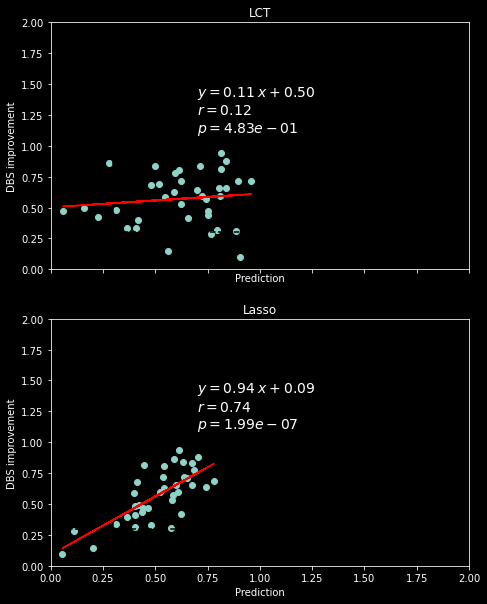

In [ ]:
pre_imp = (np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float)
util.eval_prediction(np.vstack((pre_imp,
                               results_ls_aug,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

Define probability of an unsucessful procedure as $P = 1-u$ where $u$ is the UPDRS percent improvement prediction between $0$ and $1$.

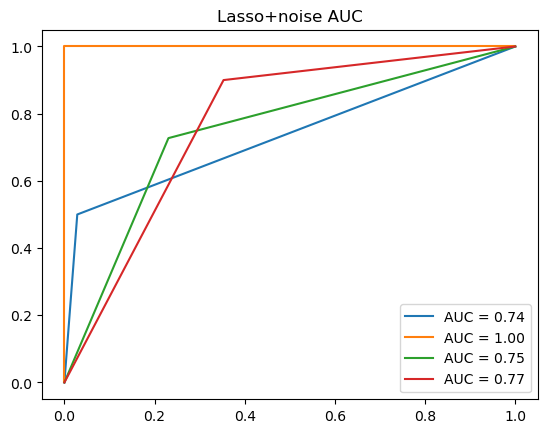

In [ ]:
t = [0.15,0.3,0.45,0.6]
for j in np.arange(len(t)):
    y_bin = per_change<t[j]
    y_predicted = results_ls_aug < t[j]#1-results_ls_aug
    fpr, tpr, _ = roc_curve(y_bin,  y_predicted)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.title('Lasso+noise AUC')
plt.legend()
plt.show()

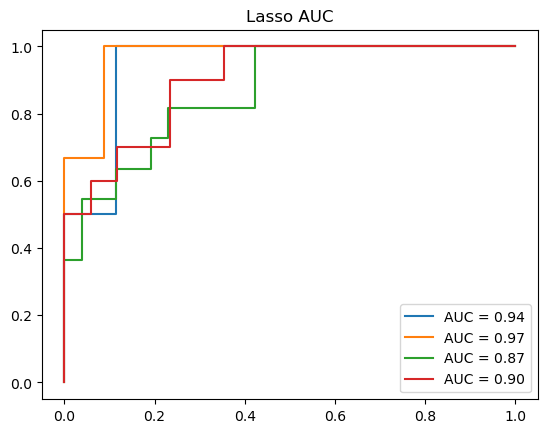

In [ ]:
t = [0.15,0.3,0.45,0.6]
for j in np.arange(len(t)):
    y_bin = per_change<t[j]
    y_predicted = 1-results_ls
    fpr, tpr, _ = roc_curve(y_bin,  y_predicted)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.title('Lasso AUC')
plt.legend()
plt.show()

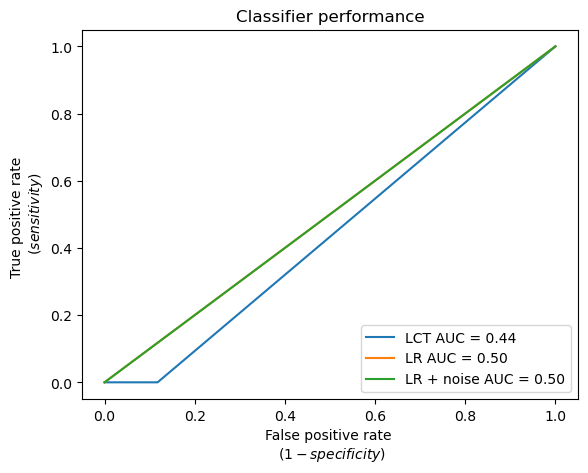

In [ ]:
t = 0.3
y_bin = per_change<t

y_predicted_ls = 1-results_ls
y_predicted_ls_aug = 1-results_ls_aug
y_predicted_lct = pre_imp < 0.3
y_predicted_aug = 1-results_lgrp_aug
y_predicted_lr = 1-results_lgrp

fprlsa, tprlsa, _ = roc_curve(y_bin,  y_predicted_ls_aug)
fprls, tprls, _ = roc_curve(y_bin,  y_predicted_ls)
fprl, tprl, _ = roc_curve(y_bin,  y_predicted_lct)
fpra, tpra, _ = roc_curve(y_bin, y_predicted_aug)
fprlr, tprlr, _ = roc_curve(y_bin, y_predicted_lr)

roc_auc_lct = auc(fprl, tprl)
roc_auc_lr = auc(fprlr, tprlr)
roc_auc_lr_aug = auc(fpra, tpra)
roc_auc_ls = auc(fprls, tprls)
roc_auc_ls_aug = auc(fprlsa, tprlsa)
plt.rcParams['legend.loc']='lower right'
plt.plot(fprl, tprl, label = 'LCT AUC = %0.2f' % roc_auc_lct)
plt.plot(fprlr, tprlr, label = 'LR AUC = %0.2f' % roc_auc_lr)
plt.plot(fpra, tpra, label = 'LR + noise AUC = %0.2f' % roc_auc_lr_aug)
# plt.plot(fprls, tprls, label = 'LASSO AUC = %0.2f' % roc_auc_ls)
# plt.plot(fprlsa, tprlsa, label = 'LASSO + noise AUC = %0.2f' % roc_auc_ls_aug)
plt.title('Classifier performance')
plt.xlabel('False positive rate \n $(1-specificity$)')
plt.ylabel('True positive rate \n $(sensitivity$)')
plt.legend()
plt.show()

In [ ]:
# t = [0.15,0.3,0.45,0.6]
# for j in np.arange(len(t)):
#     y_bin = per_change<t[j]
#     y_predicted = 1-results_lgrp
#     fpr, tpr, _ = roc_curve(y_bin,  y_predicted)
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
# plt.title('Logistic regression AUC')
# plt.legend()
# plt.show()

In [ ]:
# t = [0.15,0.3,0.45,0.6]
# for j in np.arange(len(t)):
#     y_bin = per_change<t[j]
#     y_predicted = pre_imp<t[j]
#     fpr, tpr, _ = roc_curve(y_bin,  y_predicted)
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
# plt.title('LCT AUC')
# plt.legend()
# plt.show()

In [ ]:
acc_ls_aug = util.classification_accuracy((results_ls_aug < 0.3).astype(int),(per_change < 0.3).astype(int))
sns_ls_aug = util.classification_sensitivity((results_ls_aug < 0.3).astype(int),(per_change < 0.3).astype(int))
spf_ls_aug = util.classification_specificity((results_ls_aug < 0.3).astype(int),(per_change < 0.3).astype(int))
auc_ls_aug = roc_auc_ls_aug

In [ ]:
acc_ls = util.classification_accuracy((results_ls < 0.3).astype(int),(per_change < 0.3).astype(int))
sns_ls = util.classification_sensitivity((results_ls < 0.3).astype(int),(per_change < 0.3).astype(int))
spf_ls = util.classification_specificity((results_ls < 0.3).astype(int),(per_change < 0.3).astype(int))
auc_ls = roc_auc_ls

In [ ]:
acc_lgr = util.classification_accuracy((results_lgr).astype(int),(per_change < 0.3).astype(int))
sns_lgr = util.classification_sensitivity((results_lgr).astype(int),(per_change < 0.3).astype(int))
spf_lgr = util.classification_specificity((results_lgr).astype(int),(per_change < 0.3).astype(int))
auc_lgr = roc_auc_lr

In [ ]:
acc_lgr_aug = util.classification_accuracy((results_lgr_aug).astype(int),(per_change < 0.3).astype(int))
sns_lgr_aug = util.classification_sensitivity((results_lgr_aug).astype(int),(per_change < 0.3).astype(int))
spf_lgr_aug = util.classification_specificity((results_lgr_aug).astype(int),(per_change < 0.3).astype(int))
auc_lgr_aug = roc_auc_lr_aug

In [ ]:
acc_lct = util.classification_accuracy((pre_imp < 0.3).astype(int),(per_change < 0.3).astype(int))
sns_lct = util.classification_sensitivity((pre_imp < 0.3).astype(int),(per_change < 0.3).astype(int))
spf_lct = util.classification_specificity((pre_imp < 0.3).astype(int),(per_change < 0.3).astype(int))
auc_lct = roc_auc_lct

In [ ]:
c = ['Levodopa challenge','Logistic regression','Logistic regression + noise','Lasso','Lasso + noise']
d = {'accuracy': [acc_lct,acc_lgr,acc_lgr_aug,acc_ls,acc_ls_aug], 'sensitivity': [sns_lct,sns_lgr,sns_lgr_aug,sns_ls,sns_ls_aug], 'specificity': [spf_lct,spf_lgr,spf_lgr_aug,spf_ls,spf_ls_aug], 'auc': [auc_lct,auc_lgr,auc_lgr_aug,'-','-']}
df = pd.DataFrame(index=c,data=d)


In [ ]:
df

,accuracy,sensitivity,specificity,auc
Levodopa challenge,0.810811,1.0,0.882353,0.441176
Logistic regression,0.918919,1.0,1.000000,0.5
Logistic regression + noise,0.918919,1.0,1.000000,0.5
Lasso,0.918919,1.0,1.000000,-
Lasso + noise,1.000000,1.0,1.000000,-


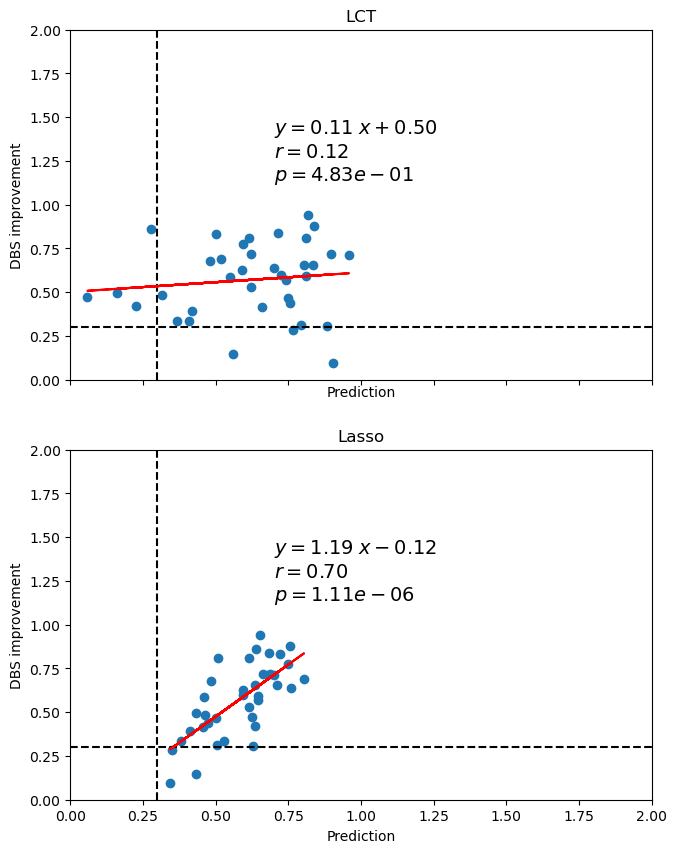

In [ ]:
pre_imp = (np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float)
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

In [ ]:
# Do wild bootstrap
# Repeat CHH with wild bootstrap and higher zscore
Js = []
aug = False
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
results_ls_wbs = np.zeros_like(per_change)
c = 0
for j in np.arange(c,len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    idy = np.where(y_cat==1)
    # Cross validation
                                          
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs_off,None,None,None,None,None,None,None,None,None,False,False,False)
    X0_ss00 = X0_ss0
    y_train_0 = y_train
    cvn = 5

    cv_scores = np.zeros((cvn,1))
    rs = 1
    rcfs = 1000
    (mu, sigma) = stats.norm.fit(y_train)
    kappa = stats.skew(y_train)
    print('Label distribution of:',mu,sigma,kappa)
    for jj in np.arange(2,cvn):
      # Resample to avoid stratification errors
      while np.sum(y_cat) < cvn:
        np.random.seed(rs)
        idyr = np.random.choice(np.asarray(idy).ravel())
        X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
        y_train = np.append(y_train,y_train[idyr])
        y_cat = y_train <= 0.3
        rs = rs+1
        print('Resampled to size',y_train.shape)
        ls0 = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        est0 = ls0.fit(X0_ss0,y_train)
        eps = y_train-ls0.predict(X0_ss0)
        eps_v = eps*np.random.normal(0,1,1)
        y_train_0 = y_train
      if aug == True:
        y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
        y_train = np.hstack((y_train,y_train_n))
        y_cat = y_train <= 0.3
        X0_ss0 = np.vstack((X0_ss0,X0_ss0))
      else: # Control for different training sample sizes
        while len(eps_v) < len(y_train):
          eps_v = np.hstack((eps_v,eps*np.random.normal(0,1,1)))
        y_train_n = y_train+eps_v
        y_train = np.hstack((y_train,y_train_n))
        y_cat = y_train <= 0.3
        X0_ss0 = np.vstack((X0_ss0,X0_ss0))

    for jj in np.arange(2,cvn):
      skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        # Feature selection
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X0_ss = X0_sst
        est_ls = lasso.fit(X0_ss,y_train)
        cv_scores[jj] = est_ls.score(X0_ss,y_train)
        print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      best_cv = np.argmax(cv_scores)
      # Break any ties
      if np.sum(cv_scores == best_cv) > 1:
        cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
        for jjj in (cv_scores == cv_scores(best_cv)):
          if jjj > 0:
            skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
            skf_gen = skf_g.split(X0_ss0,y_cat) 
            X0_sst = sel.fit_transform(X0_ss0,y_train)
            X0_ss = X0_sst
            lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
            est_ls = lasso.fit(X0_ss,y_train)
            cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
        best_cv = np.argmax(cv_scores_tb)
      
      # Fit whole dataset with optimal cv
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      X_test_sst = sel.transform(X_test_ss0)
      X0_ss = X0_sst
      X_test_ss = X_test_sst

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      est_ls = lasso.fit(X0_ss,y_train)
      results_ls_wbs[c] = est_ls.predict(X_test_ss)
      if results_ls_wbs[c] < 0:
          dx, y_n = cKDTree(X0_ss00.reshape(X0_ss00.shape[0],-1)).query(X_test_ss0.reshape(1,-1),k=15)
          results_ls_wbs[c] = np.mean((y_train_0[y_n]))
          print('Using nearest neighbor')
      print('Lasso predicts',str(np.round(results_ls_wbs[c],4)),
            'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
      try:
        K_nz.append(np.squeeze(K_ss)[est_ls.coef_>0])
      except:
        print('No features appended')
      c=c+1


      

  


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.99543534] from dataset of size (304, 385)
LassoCV score for 3 is [0.99543584] from dataset of size (304, 6385)
LassoCV score for 4 is [0.99543497] from dataset of size (304, 3385)
Lasso predicts 0.7057 for case with 0.72 and selected CV 3
No features appended
Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.99787181] from dataset of size (304, 4385)
LassoCV score for 3 is [0.99787181] from dataset of size (304, 3385)
LassoCV score for 4 is [0.99787181] from dataset of size (304, 4385)
Lasso predicts 0.4956 for case with 0.47 and selected CV 2
No features appended
Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.99412336]

In [ ]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1-data2                   # Difference between datasets
    md        = np.mean(diff)                 # Mean of the difference
    sd        = np.std(diff, axis=0)          # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.text(0.1, 2*md, r'$\mu$ = '+str(np.round(md,2)), horizontalalignment='center',verticalalignment='center')
    plt.text(0.5, 0.4, r'$\mu + 1.96 \sigma$ = '+str(np.round(md + 1.96*sd,2)), horizontalalignment='center',verticalalignment='center')
    plt.text(0.5, -0.5, r'$\mu - 1.96 \sigma$ = '+str(np.round(md - 1.96*sd,2)), horizontalalignment='center',verticalalignment='center')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.ylim([-4*1.96*sd,4*1.96*sd])
    diff_in = np.logical_and(diff < md + 1.96*sd,diff > md - 1.96*sd)
    plt.scatter(mean[diff_in], diff[diff_in], *args, **kwargs)
    # print(sum(diff_in))
    # print(len(diff))
    # print('Number of features outside limits of agreement:',len(diff)-sum(diff_in),'of',len(diff),'evaluated features')
    # print('Limits of agreement are:',str(md-1.96*sd),str(md+1.96*sd))
    # print('Fraction of features within limits of agreement: ',str(sum(diff_in)/len(diff.ravel())))
    plt.xlabel(r'$\frac{y_{true}+y_{predicted}}{2}$',fontsize=16)
    plt.ylabel(r'$y_{predicted}-y_{true}$',fontsize=12)
    return diff,diff_in

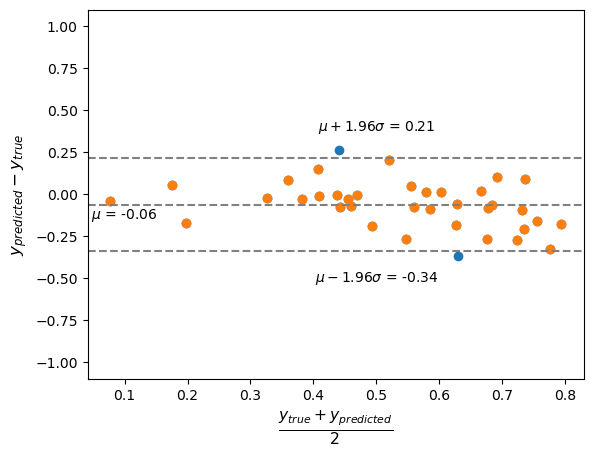

In [ ]:
d,din = bland_altman_plot(results_ls_aug,per_change)

(0.0, 1.25)

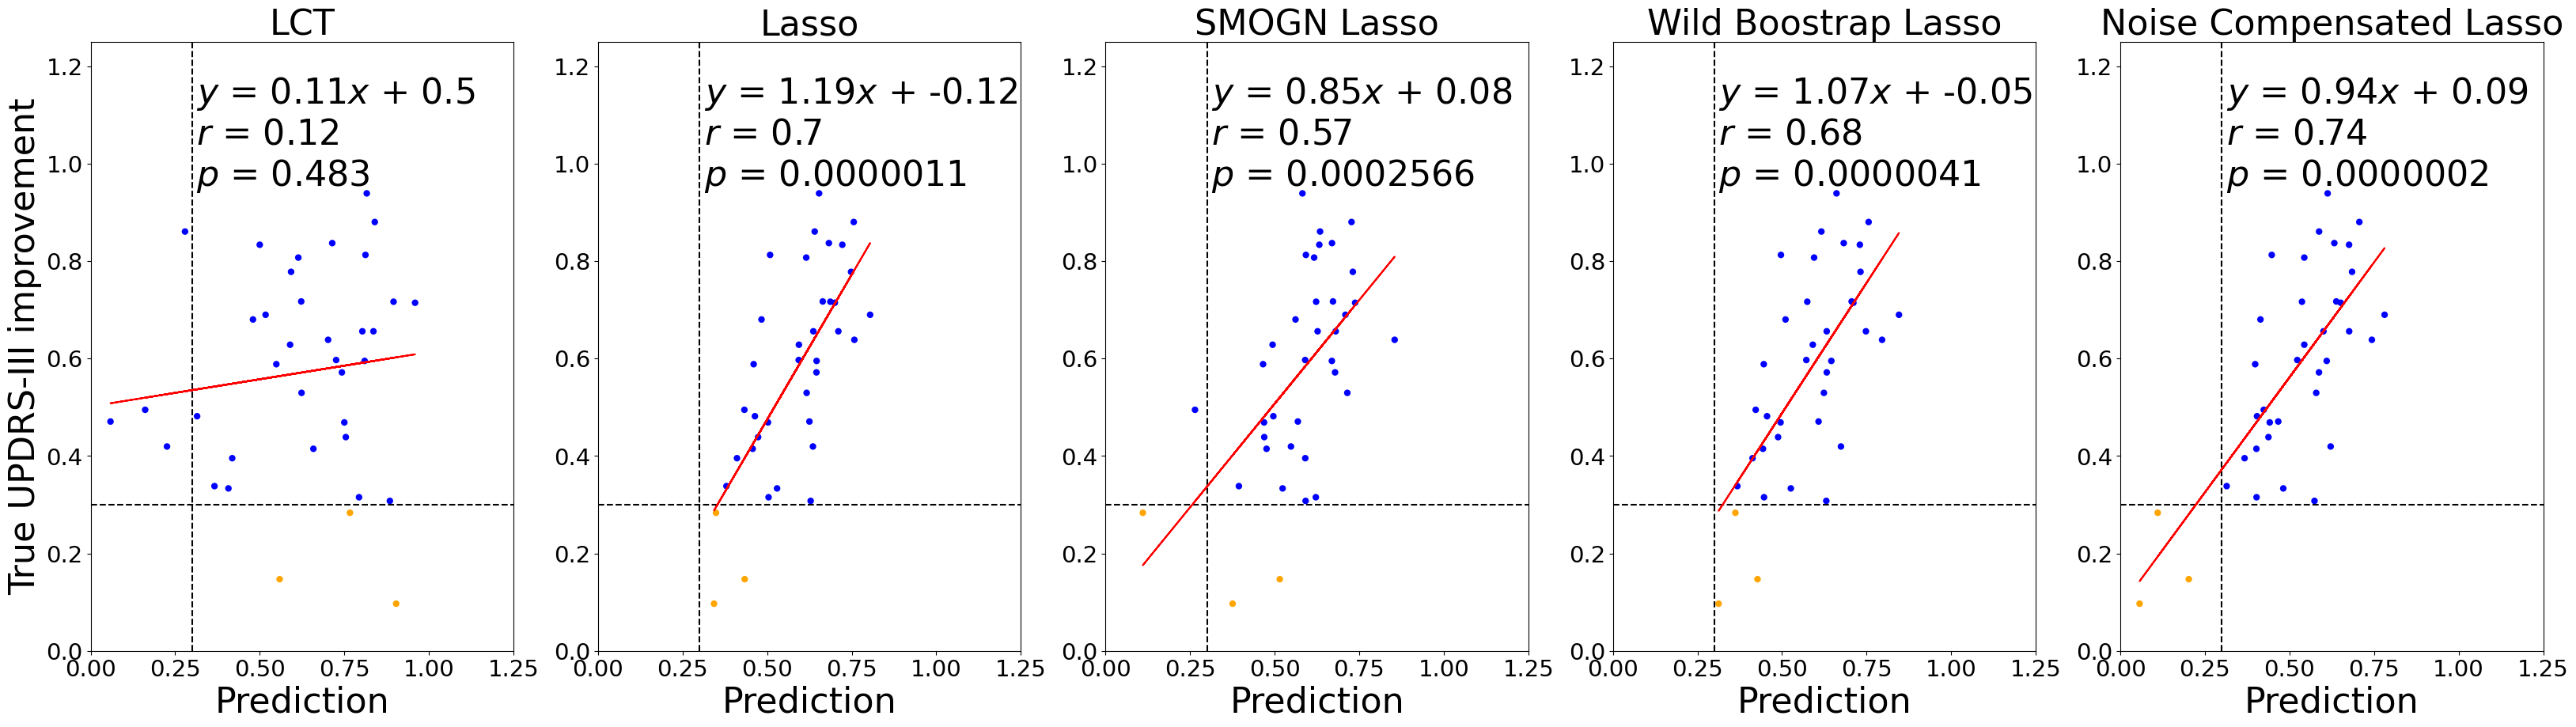

In [63]:
ylim = 1.25
fs = 32
ofx = 0.25
ofy = 0.75
pre_imp = np.repeat((np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float),r)
per_change = np.repeat(per_change,r)
plt.rcParams['figure.figsize'] = [40, 10]
fig,ax = plt.subplots(1,5,sharex=True,sharey=True)
#ax[0].scatter(pre_imp,per_change)
col = np.where(per_change <= 0.3,'orange','blue')
ax[0].scatter(pre_imp,per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0].plot(pre_imp,y_model,color='r')
ax[0].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0].transAxes,fontsize=fs)  
ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].set_title('LCT',fontsize=fs)
ax[0].set_xlabel('Prediction',fontsize=fs)
ax[0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0].set_ylabel('True UPDRS-III improvement',fontsize=fs)
ax[0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
col = np.where(per_change <= 0.3,'orange','blue')

ax[1].scatter(results_ls,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls),per_change)
y_model = results_ls*lr.slope+lr.intercept
ax[1].plot(results_ls,y_model,color='r')
ax[1].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1].transAxes,fontsize=fs) 
ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].set_title('Lasso',fontsize=fs)
ax[1].set_xlabel('Prediction',fontsize=fs)
ax[1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
# ax[1].set_ylabel('True Improvement',fontsize=fs)
ax[1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
col = np.where(per_change <= 0.3,'orange','blue')


ax[2].scatter(results_ls_smogn,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_smogn),per_change)
y_model = results_ls_smogn*lr.slope+lr.intercept
ax[2].plot(results_ls_smogn,y_model,color='r')
ax[2].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[2].transAxes,fontsize=fs) 
ax[2].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[2].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[2].set_xlabel('Prediction',fontsize=fs)
ax[2].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
# ax[2].set_ylabel('True Improvement',fontsize=fs)
ax[2].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[2].set_title('SMOGN Lasso',fontsize=fs)

ax[3].scatter(results_ls_wbs,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_wbs),per_change)
y_model = results_ls_wbs*lr.slope+lr.intercept
ax[3].plot(results_ls_wbs,y_model,color='r')
ax[3].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[3].transAxes,fontsize=fs) 
ax[3].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[3].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[3].set_xlabel('Prediction',fontsize=fs)
ax[3].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
# ax[3].set_ylabel('True Improvement',fontsize=fs)
ax[3].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[3].set_title('Wild Boostrap Lasso',fontsize=fs)

ax[4].scatter(results_ls_aug,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_aug),per_change)
y_model = results_ls_aug*lr.slope+lr.intercept
ax[4].plot(results_ls_aug,y_model,color='r')
ax[4].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[4].transAxes,fontsize=fs) 
ax[4].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[4].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[4].set_xlabel('Prediction',fontsize=fs)
ax[4].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
# ax[4].set_ylabel('True Improvement',fontsize=fs)
ax[4].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[4].set_title('Noise Compensated Lasso',fontsize=fs)
plt.ylim([0,ylim])
plt.xlim([0,ylim])



KeyError: 0

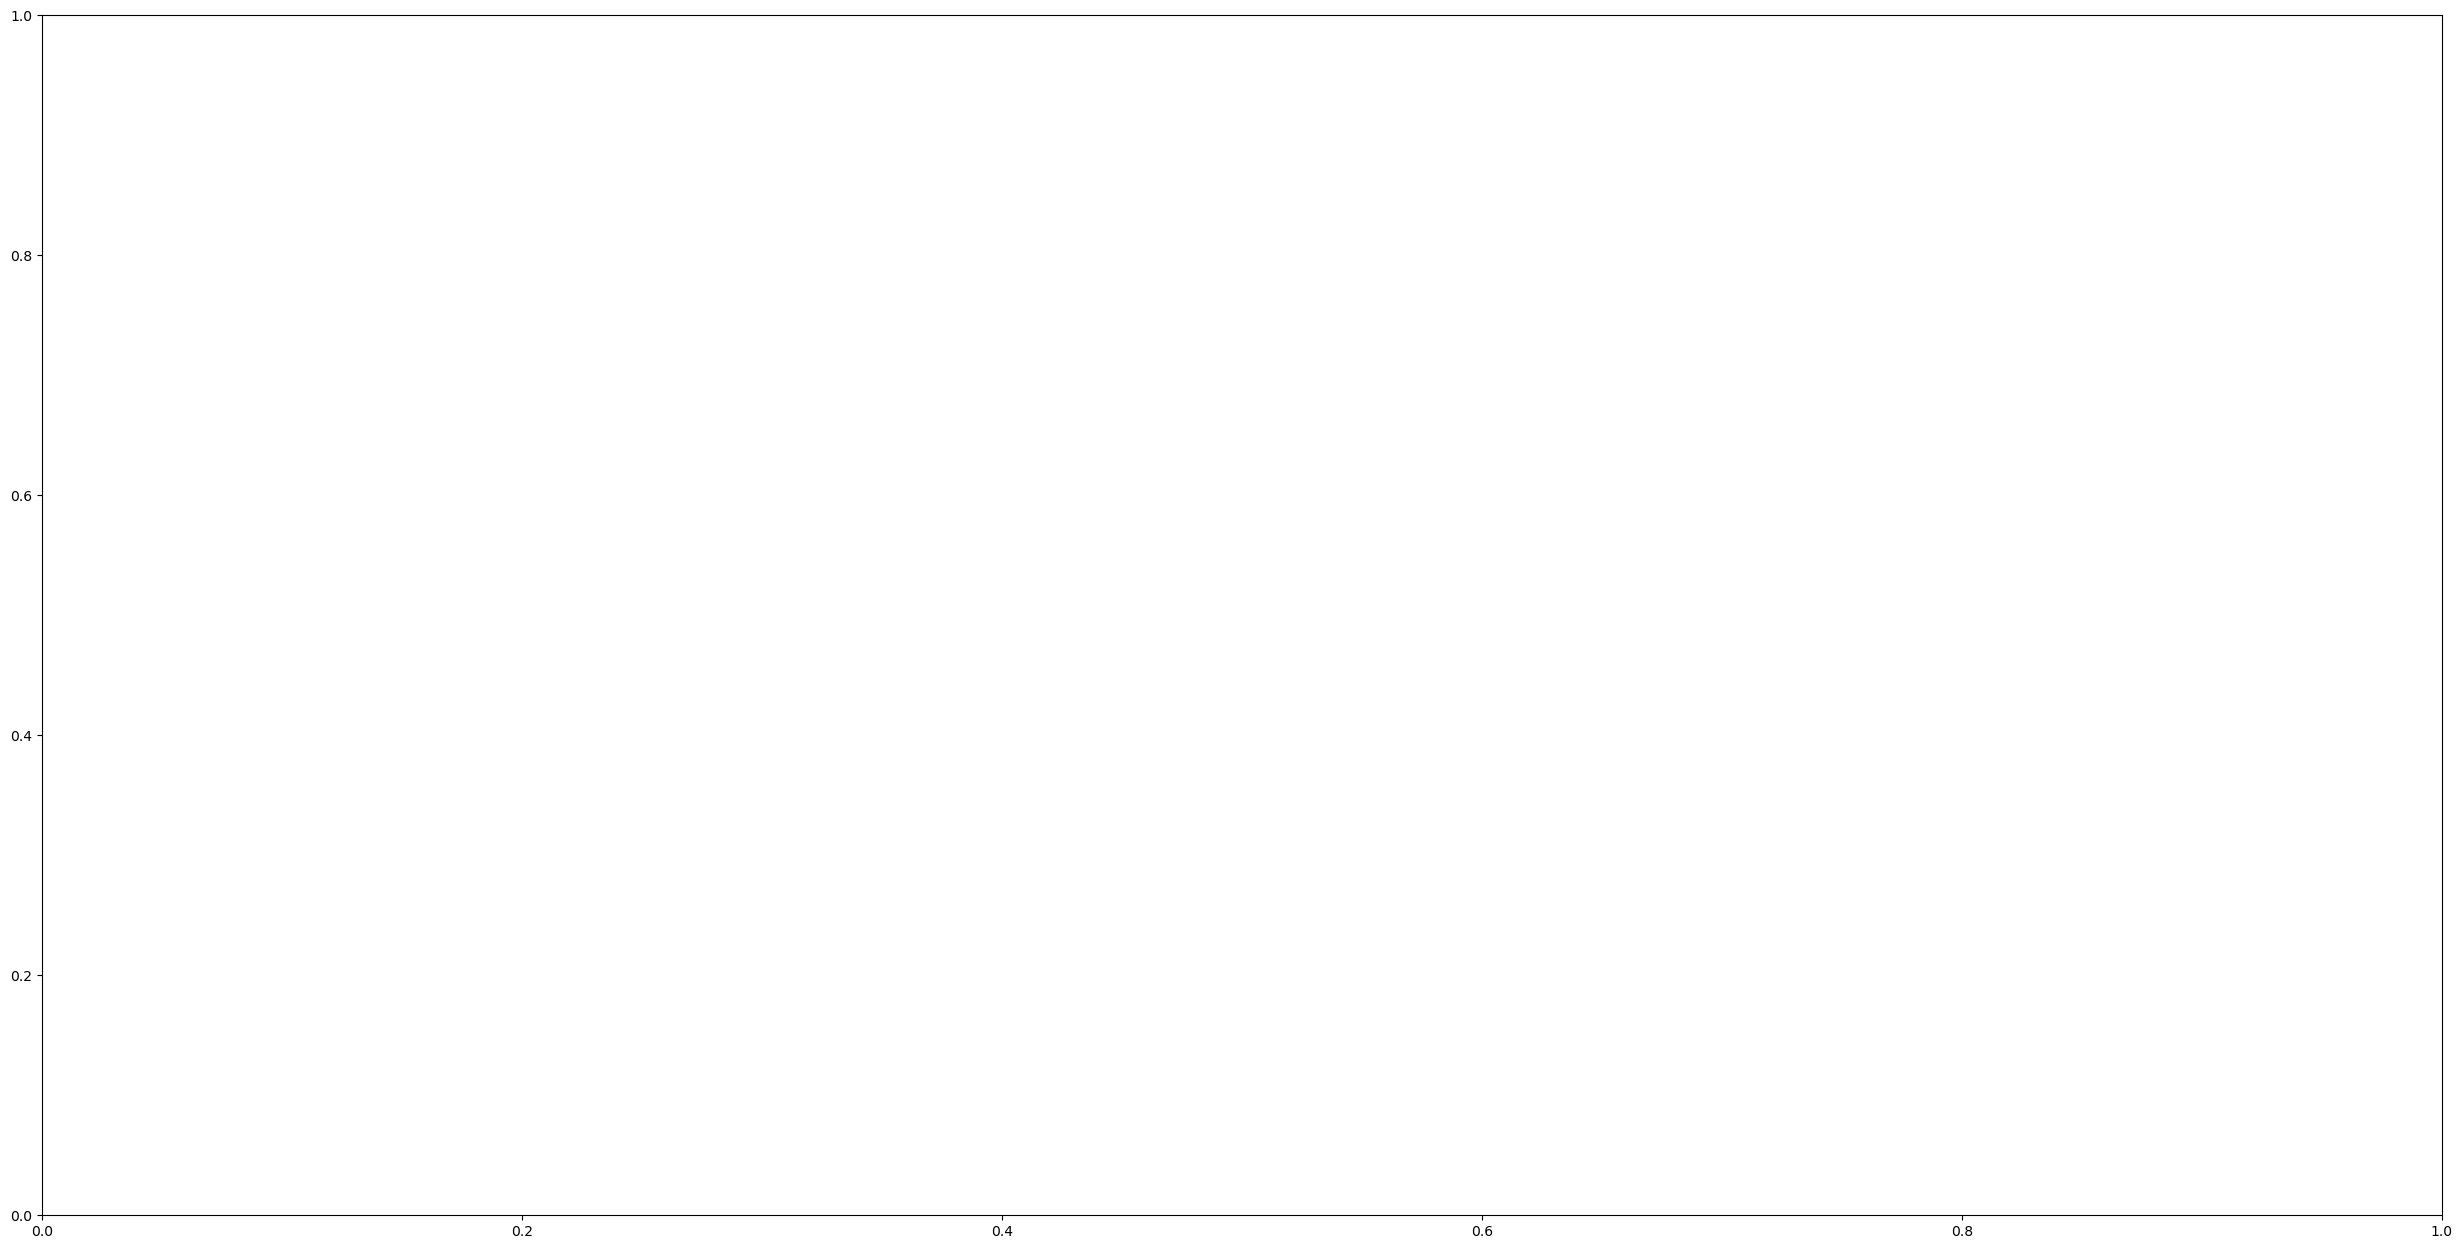

In [ ]:
from collections import Counter

plt.rcParams["figure.figsize"] = (30,15)
fig, axes = plt.subplots(1,1,sharey=True)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

R = [item for sublist in K_nz for item in sublist]
letter_counts = Counter(R)
lc = { x: count for x, count in letter_counts.items() if count > 1 }
df = pd.DataFrame.from_dict(lc, orient='index')
df.sort_values(0, ascending=False, inplace=True)
df.plot(ax=axes, y=0, kind='bar', legend=False, fontsize=16)
plt.title('Predictive radiomic features',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

plt.style.use('default')

In [ ]:
results_ls_aug_clt = np.zeros_like(per_change)
results_lgr_aug_clt = np.zeros_like(per_change)
results_lgrp_aug_clt = np.zeros_like(per_change)

In [ ]:
retrain = 1
if retrain == 1:

  Js = []
  aug = True
  err_var = np.zeros_like(per_change)
  rerror = np.zeros_like(per_change)
  kappa = []
  K_nz = []
  E_nz = []
  c = 0

  K_all_c = np.append(K_all_c,['pre updrs']*5)
  for j in np.arange(len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
                                            
      X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_off,None,None,None,None,None,None,None,None,None,False,False,False)
      cvn = 5
      cv_scores = np.zeros((cvn,1))
      cv_lgr_scores = np.zeros((cvn,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train)
      kappa = stats.skew(y_train)
      print('Label distribution of:',mu,sigma,kappa)
      for jj in np.arange(2,cvn):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
          y_train = np.append(y_train,y_train[idyr])
          y_cat = y_train <= 0.3
          rs = rs+1
          print('Resampled to size',y_train.shape)
        if aug == True:
          # y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
          z_train = (y_train-np.mean(y_train))/(np.std(y_train)/np.sqrt(len(y_train)))
          z_train_ns = z_train+1.96*np.std(z_train)*np.random.normal(0,1,1)
          y_train_n = z_train_ns*((np.std(y_train)/np.sqrt(len(y_train))))+np.mean(y_train)
          y_train = np.hstack((y_train,y_train_n))
          y_cat = y_train <= 0.3
          X0_ss0 = np.vstack((X0_ss0,X0_ss0))
      
      for jj in np.arange(2,cvn):
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          # Feature selection
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen,n_jobs=1)
          # Stratifies classifiers automatically
          sel_lr = skf.RFECV(lgr,step=rcfs,cv=jj,n_jobs=1)
          X0_ss = sel.fit_transform(X0_ss0,y_train)
          X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
          est_ls = lasso.fit(X0_ss,y_train)
          est_lgr = lgr.fit(X0_ssl,y_cat)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          cv_lgr_scores[jj] = est_lgr.score(X0_ssl,y_cat)
          print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        best_cv_lgr = np.argmax(cv_lgr_scores)

        # Break any ties
        if np.sum(cv_scores == best_cv) > 1:
          cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
          cv_lgr_scores_tb = np.zeros((np.sum(cv_scores == best_cv_lgr),1))
          for jjj in (cv_scores == cv_scores[best_cv]):
            if jjj > 0:
              print('Breaking tie')
              skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
              skf_gen = skf_g.split(X0_ss0,y_cat) 
              X0_ss = sel.fit_transform(X0_ss0,y_train)
              X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
              est_ls = lasso.fit(X0_ss,y_train)
              est_lgr = lgr.fit(X0_ssl,y_cat)
              lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
              lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
              est_ls = lasso.fit(X0_ss,y_train)
              est_lgr = lgr.fit(X0_ssl,y_cat)
              cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
              cv_lgr_scores_tb[jj] = est_lgr.score(sel_lr.fit_transform(X0_ss0,y_cat),y_cat)
          best_cv = np.argmax(cv_scores_tb)
          best_cv_lgr = np.argmax(cv_lgr_scores_tb)
        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        sel_lr = skf.RFECV(lgr,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
        X_test_ssl = sel_lr.transform(X_test_ss0)
        K_ss = sel.transform(K_all_c.reshape(1,-1))

      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv,class_weight=None)
        est_ls = lasso.fit(X0_ss,y_train)
        est_lgr = lgr.fit(X0_ssl,y_cat)
      results_lgr_aug_clt[c] = est_lgr.predict(X_test_ssl)
      results_lgrp_aug_clt[c] = est_lgr.predict_proba(X_test_ssl)[0][0]
      results_ls_aug_clt[c] = est_ls.predict(X_test_ss)
      print('Lasso predicts',str(np.round(results_ls_aug_clt[c],4)),'and logistic regression predicts',results_lgr_aug_clt[c],
                'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv,'and',sum(y_cat),'minority cases')
      K_nz.append(np.squeeze(K_ss)[est_ls.coef_>0])
      E_nz.append(est_ls.coef_[est_ls.coef_>0])
      c=c+1

  # np.save('results_ls_aug_d.npy',results_ls_aug)
  # np.save('results_lgr_aug_d.npy',results_lgr_aug)
  # np.save('results_lgrp_aug_d.npy',results_lgrp_aug)

else:
  print('Loading')
  # results_ls_aug = np.load('results_ls_aug_d.npy')
  # results_lgr_aug = np.load('results_lgr_aug_d.npy')
  #results_lgrp_aug = np.load('results_lgr_aug_d.npy')

  


In [ ]:
len(y_cat)

In [ ]:
pre_imp = (np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float)
util.eval_prediction(np.vstack((pre_imp,
                               results_ls_aug_clt,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

In [ ]:
y_predicted_aug_clt = 1-results_lgrp_aug_clt
fprac, tprac, _ = roc_curve(y_bin, y_predicted_aug_clt)
roc_auc_lr_aug_clt = auc(fprac, tprac)

acc_lgr_aug = util.classification_accuracy((results_lgr_aug_clt).astype(int),(per_change < 0.3).astype(int))
sns_lgr_aug = util.classification_sensitivity((results_lgr_aug_clt).astype(int),(per_change < 0.3).astype(int))
spf_lgr_aug = util.classification_specificity((results_lgr_aug_clt).astype(int),(per_change < 0.3).astype(int))
auc_lgr_aug_clt = roc_auc_lr_aug_clt

In [ ]:
acc_lgr_aug